In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from IPython.display import display, clear_output

In [2]:
%matplotlib inline

In [3]:
def binom_err(bins_nom, bins_denom):
    p = bins_nom/bins_denom
    q = 1-p
    return np.sqrt(q*(1-p)/bins_denom)

In [4]:
muon_mass = 0.105658

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])
eps= np.array([-0.001, 0.001])


main_tree_name = 'cosmicstudies'
flash_name = b'SimpleCosmicFlashes'

outdir = './Output/SimpleCosmicFlash/'
# Input file lists
file_name_mc = './input/CosmicStudies_mc_96k.root'
file_name_data = './input/CosmicStudies_data_6470.root'

In [5]:
file_mc = uproot.open(file_name_mc)[main_tree_name]
file_data = uproot.open(file_name_data)[main_tree_name]

In [6]:
file_data.keys()

[b'pot;1',
 b'Event;1',
 b'OpBeamFlashes;1',
 b'SimpleBeamFlashes;1',
 b'OpCosmicFlashes;1',
 b'SimpleCosmicFlashes;1',
 b'PFParticles;1',
 b'Clusters;1']

In [7]:
df_flash_mc = file_mc[flash_name].pandas.df()
df_flash_data = file_data[flash_name].pandas.df()

In [8]:
df_event_mc = file_mc[b'Event'].pandas.df()
df_event_data = file_data[b'Event'].pandas.df()
print(len(df_event_mc))

119000


In [9]:
df_mcp = file_mc[b'MCParticles'].pandas.df()

6651325
862.749643


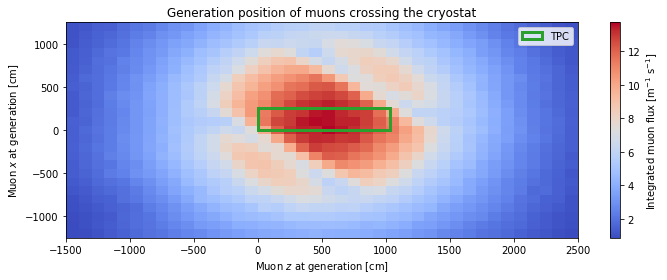

In [10]:
# Make a plot of the muon density at the generation!
df_mcp_gen = df_mcp.query('(mc_process==23) & (mc_pdg_code==13 | mc_pdg_code==-13)')
print(len(df_mcp_gen))
# Time in seconds of the sample
total_time = (max(df_mcp_gen['mc_time'])-min(df_mcp_gen['mc_time']))*1e-9*len(df_event_mc) 
print(total_time)
# Area in m*m
total_area = (40)*(25)
weights = np.full((len(df_mcp_gen)), (25*40)/total_area/total_time)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
c = ax.hist2d(df_mcp_gen["mc_startz"],df_mcp_gen["mc_startx"], range=((-1500,2500),(-1250,1250)), 
              cmap='coolwarm', bins=(40,25), weights=weights)
clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-1}$ s$^{-1}$]')
rect = patches.Rectangle((det_z[0],det_x[0]),det_z[1]-det_z[0],det_x[1]-det_x[0],
                         linewidth=3,edgecolor='C2',facecolor='none', label='TPC')
ax.add_patch(rect)
ax.legend()
ax.set_ylabel(r'Muon $x$ at generation [cm]')
ax.set_xlabel(r'Muon $z$ at generation [cm]')
ax.set_title('Generation position of muons crossing the cryostat')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/startxz_generation.pdf", bbox_inches="tight")

In [11]:
df_mcp_gen.columns
df_mcp_gen['mc_part_inside'].value_counts()

True     4695207
False    1956118
Name: mc_part_inside, dtype: int64

In [12]:
primary_query = '(mc_process==23)'
muon_query = '(mc_pdg_code==13 | mc_pdg_code==-13)'
cross_query = '(mc_length_tpc>10)' 
exit_tpc = '(mc_end_inside==0)'

# Fix the bug that some particles actually did not cross the tpc but seem to do
df_mc_prim_cross = df_mcp.query(primary_query +' & '+ cross_query) #+' & '+ ybug_query)

cross_primary_fraction = len(df_mc_prim_cross.query(muon_query))/len(df_mc_prim_cross)
print(df_mc_prim_cross['mc_pdg_code'].value_counts()/len(df_mc_prim_cross))
print('Fraction of crossing primaries that is an (anti-)muon: {0:.2f}%'.format(cross_primary_fraction*100))
df_mc_prim_exit = df_mc_prim_cross.query(exit_tpc)
exit_primary_fraction = len(df_mc_prim_exit.query(muon_query))/len(df_mc_prim_exit)
print(df_mc_prim_exit['mc_pdg_code'].value_counts())
print('Fraction of exiting crossing primaries that is an (anti-)muon: {0:.2f}%'.format(exit_primary_fraction*100))

df_mc_muon_cross = df_mc_prim_cross.query(muon_query).copy()
df_mc_primary = df_mcp.query(primary_query).copy()
del df_mcp # free the memory of the original frame!
df_mc_muon_cross['Kinetic Energy'] = df_mc_muon_cross['mc_energy']-muon_mass

# Conclusion: the primaries inside the TPC are mainly muons, 3% are neutrons.

-13      0.526186
 13      0.438927
 2112    0.032322
 2212    0.001512
 22      0.000463
-11      0.000285
 11      0.000273
-211     0.000014
 211     0.000014
-2212    0.000002
-2112    0.000001
Name: mc_pdg_code, dtype: float64
Fraction of crossing primaries that is an (anti-)muon: 96.51%
-13      2275765
 13      1895259
 2112      41457
 2212       2113
-11         1293
 11         1239
 22          381
-211          14
 211          14
-2112          3
-2212          2
Name: mc_pdg_code, dtype: int64
Fraction of exiting crossing primaries that is an (anti-)muon: 98.90%


## Plots done for MCP muons

In [13]:
# You created a frame with only primary muons! This is okay up to 1/1000
print(df_mc_muon_cross.columns)

Index(['event', 'run', 'subrun', 'num_mcp', 'num_mcp_saved', 'mc_energy',
       'mc_pdg_code', 'mc_status_code', 'mc_process', 'mc_is_matched',
       'mc_start_inside', 'mc_end_inside', 'mc_part_inside',
       'mc_neutrino_origin', 'mc_time', 'mc_startx', 'mc_starty', 'mc_startz',
       'mc_startx_tpc', 'mc_starty_tpc', 'mc_startz_tpc', 'mc_endx', 'mc_endy',
       'mc_endz', 'mc_endx_tpc', 'mc_endy_tpc', 'mc_endz_tpc',
       'mc_startmomentumx', 'mc_startmomentumy', 'mc_startmomentumz',
       'mc_length', 'mc_length_tpc', 'Kinetic Energy'],
      dtype='object')


In [14]:
# Are all muons primary? 
df_mc_muon_cross['mc_process'].value_counts()
# up to 1/1000, yes!

23    4600300
Name: mc_process, dtype: int64

In [15]:
# Do all muons start outside the TPC?
df_mc_muon_cross['mc_end_inside'].value_counts()
# Yes!

False    4171024
True      429276
Name: mc_end_inside, dtype: int64

In [16]:
# What fraction of muons stop inside the TPC?
stopping_fraction = df_mc_muon_cross['mc_end_inside'].value_counts().values[1]/len(df_mc_muon_cross)
print('Fraction of stopping muons: {0:.2f}%'.format(stopping_fraction*100))

Fraction of stopping muons: 9.33%


In [17]:
# Do all primary particles start at +18m above the detector?
print(df_mc_primary['mc_starty'].value_counts().values[0]/len(df_mc_primary))
# Yes!

1.0


[0.1        0.1244898  0.14897959 0.17346939 0.19795918 0.22244898
 0.24693878 0.27142857 0.29591837 0.32040816 0.34489796 0.36938776
 0.39387755 0.41836735 0.44285714 0.46734694 0.49183673 0.51632653
 0.54081633 0.56530612 0.58979592 0.61428571 0.63877551 0.66326531
 0.6877551  0.7122449  0.73673469 0.76122449 0.78571429 0.81020408
 0.83469388 0.85918367 0.88367347 0.90816327 0.93265306 0.95714286
 0.98163265 1.00612245 1.03061224 1.05510204 1.07959184 1.10408163
 1.12857143 1.15306122 1.17755102 1.20204082 1.22653061 1.25102041
 1.2755102  1.3        1.3244898  1.34897959 1.37346939 1.39795918
 1.42244898 1.44693878 1.47142857 1.49591837 1.52040816 1.54489796
 1.56938776 1.59387755 1.61836735 1.64285714 1.66734694 1.69183673
 1.71632653 1.74081633 1.76530612 1.78979592 1.81428571 1.83877551
 1.86326531 1.8877551  1.9122449  1.93673469 1.96122449 1.98571429
 2.01020408 2.03469388 2.05918367 2.08367347 2.10816327 2.13265306
 2.15714286 2.18163265 2.20612245 2.23061224 2.25510204 2.2795

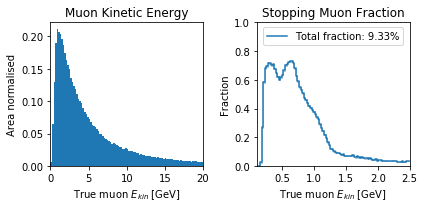

In [19]:
# make a plot of the muon kinetic energy and the fraction of stopping muons in function of that!
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
N=100
edges = np.linspace(0,20,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(df_mc_muon_cross['Kinetic Energy'], bins=edges, density=1)
ax[0].set_xlim(0,20)
ax[0].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[0].set_ylabel('Area normalised')
ax[0].set_title('Muon Kinetic Energy')

N=98
edges = np.linspace(0.1,2.5,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
denom,_ = np.histogram(df_mc_muon_cross['Kinetic Energy'], bins=edges)
nom,_ = np.histogram(df_mc_muon_cross.query('mc_end_inside')['Kinetic Energy'], bins=edges)
fraq = nom/denom
print(edges)
print(nom)
print(denom)
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Total fraction: {0:.2f}%'.format(stopping_fraction*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')
ax[1].set_xlim(0.1,2.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Stopping Muon Fraction')
ax[1].legend(loc='upper center')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muon_E.pdf", bbox_inches="tight")

In [19]:
z_safe = det_z-eps
z_safe[1]

1036.8990000000001

Muon flux: 136.18 muons/(m*s)


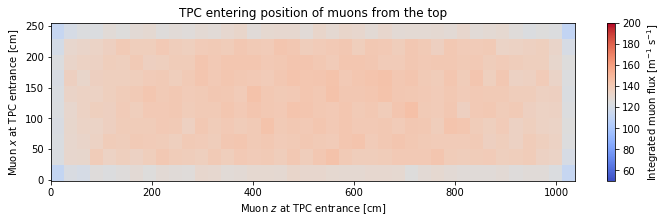

In [20]:
# Make a plot of the muon density at TPC entrance!
fig, ax = plt.subplots(1, 1, figsize=(10, 3.2))

np.full((2, 2), np.inf)

x_bin = 10
z_bin = 40
z_safe = det_z-eps
x_safe = det_x-eps

# Time in seconds of the sample
total_time = (max(df_mc_muon_cross['mc_time'])-min(df_mc_muon_cross['mc_time']))*1e-9*len(df_event_mc) 
# Area in m*m
total_area = (det_x[1]-det_x[0])*(det_z[1]-det_z[0])/1e4
weights = np.full((len(df_mc_muon_cross["mc_startz_tpc"])), (x_bin*z_bin)/total_area/total_time)

c = ax.hist2d(df_mc_muon_cross["mc_startz_tpc"],df_mc_muon_cross["mc_startx_tpc"], 
              range=((z_safe[0], z_safe[1]), (x_safe[0], x_safe[1])), 
              cmap='coolwarm', bins=(z_bin,x_bin), weights=weights, vmin=50,vmax=200)

clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-1}$ s$^{-1}$]')

ax.set_ylabel(r'Muon $x$ at TPC entrance [cm]')
ax.set_xlabel(r'Muon $z$ at TPC entrance [cm]')
ax.set_title('TPC entering position of muons from the top')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/startxz_crossing.pdf", bbox_inches="tight")

loc_query = '(mc_startz_tpc>@z_safe[0]) & (mc_startz_tpc< @z_safe[1]) & \
             (mc_startx_tpc>@x_safe[0]) & (mc_startx_tpc< @x_safe[1])'
rate = len(df_mc_muon_cross.query(loc_query)["mc_startz_tpc"])/total_area/total_time
print('Muon flux: {0:.2f} muons/(m*s)'.format(rate))

In [21]:
# What is the total time of the MC sample in seconds?
(max(df_mc_muon_cross['mc_time'])-min(df_mc_muon_cross['mc_time']))*1e-9*len(df_event_mc)

862.7495835000001

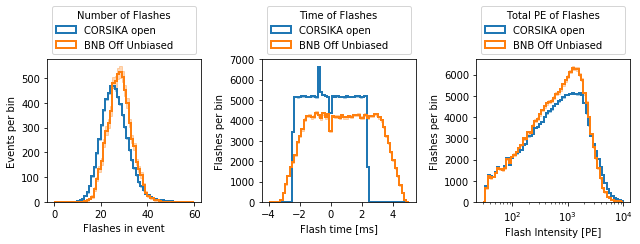

In [22]:
# number of flashes per event, PE of flashes, time of flashes
# data vs MC
# before and after timing cut

fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))

mc_scale = len(df_event_data)/len(df_event_mc) 


N=60
#Num flashes
edges=np.linspace(0,60,N+1)
bins_mc,_,_ = ax[0].hist(df_event_mc['num_simplecosmicflashes'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_event_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(df_event_data['num_simplecosmicflashes'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Number of Flashes', loc='lower center', mode='expand')
ax[0].set_ylabel('Events per bin')
ax[0].set_xlabel('Flashes in event')

#Time flashes
edges=np.linspace(-4,5,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Time of Flashes', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash time [ms]')

#PE flashes
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
bins_mc,_,_ = ax[2].hist(df_flash_mc['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[2].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[2].hist(df_flash_data['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[2].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Total PE of Flashes', loc='lower center', mode='expand')
ax[2].set_ylabel('Flashes per bin')
ax[2].set_xlabel(r'Flash Intensity [PE]')
ax[2].set_xscale("log", nonposx='clip')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_beforetime.pdf", bbox_inches="tight")

In [23]:
df_flash_mc['flash_time'].describe()

count    3.060470e+06
mean    -5.774506e+01
std      1.383392e+03
min     -2.449906e+03
25%     -1.242141e+03
50%     -8.750781e+01
75%      1.142996e+03
max      2.350406e+03
Name: flash_time, dtype: float64

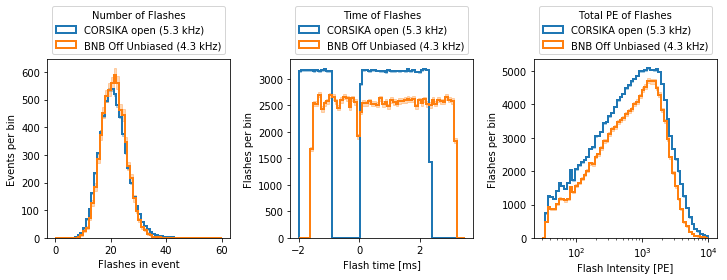

In [24]:
mc_bounds = [25,2350,-900,-2450]
time_query_mc= '((flash_time>@mc_bounds[0]) & (flash_time<@mc_bounds[1])) | \
                ((flash_time<@mc_bounds[2]) & (flash_time>@mc_bounds[3]))' 
time_mc = (4800-925)*1e-6

data_bounds = [25,3200,-5,-1600]
time_query_data= '((flash_time>@data_bounds[0]) & (flash_time<@data_bounds[1])) | \
                  ((flash_time<@data_bounds[2]) & (flash_time>@data_bounds[3]))'
time_data = (4800-30)*1e-6

df_flash_mc_time = df_flash_mc.query(time_query_mc)
df_flash_data_time = df_flash_data.query(time_query_data)

mc_rate = len(df_flash_mc_time)/(len(df_event_mc)*time_mc)/1000
data_rate = len(df_flash_data_time)/(len(df_event_data)*time_data)/1000


num_flash_mc = df_flash_mc_time.groupby(['run', 'subrun', 'event']).size()
num_flash_data = df_flash_data_time.groupby(['run', 'subrun', 'event']).size()

fig, ax = plt.subplots(1, 3, figsize=(10.2, 4))
mc_scale = len(df_event_data)/len(df_event_mc) 


N=60
#Num flashes
edges=np.linspace(0,60,N+1)
bins_mc,_,_ = ax[0].hist(num_flash_mc, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', 
                         weights=[mc_scale]*len(df_event_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(num_flash_data, bins=edges, histtype='step', lw=2,
                           label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Number of Flashes', loc='lower center', mode='expand')
ax[0].set_ylabel('Events per bin')
ax[0].set_xlabel('Flashes in event')

#Time flashes
edges=np.linspace(-2,3.5,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc_time['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data_time['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Time of Flashes', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash time [ms]')

#PE flashes
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
bins_mc,_,_ = ax[2].hist(df_flash_mc_time['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[2].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[2].hist(df_flash_data_time['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[2].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Total PE of Flashes', loc='lower center', mode='expand')
ax[2].set_ylabel('Flashes per bin')
ax[2].set_xlabel(r'Flash Intensity [PE]')
ax[2].set_xscale("log", nonposx='clip')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_aftertime.pdf", bbox_inches="tight")

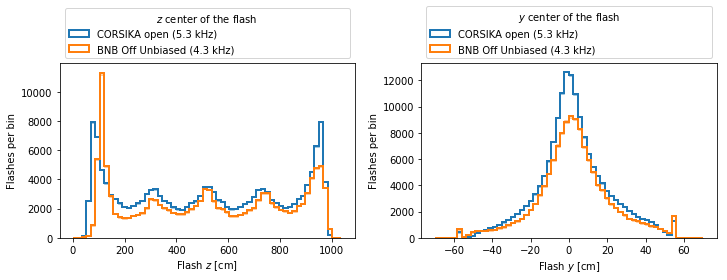

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10.2, 4))
mc_scale = len(df_event_data)/len(df_event_mc) 


N=60

#Time flashes
edges=np.linspace(0,1036.8,N+1)
bins_mc,_,_ = ax[0].hist(df_flash_mc_time['flash_z'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(df_flash_data_time['flash_z'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'$z$ center of the flash', loc='lower center', mode='expand')
ax[0].set_ylabel('Flashes per bin')
ax[0].set_xlabel(r'Flash $z$ [cm]')

#PE flashes
edges=np.linspace(-70,70,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc_time['flash_y'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data_time['flash_y'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'$y$ center of the flash', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash $y$ [cm]')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_aftertime_yz.pdf", bbox_inches="tight")

In [28]:
# Correct for 8us dead time after each flash!
from scipy.optimize import fsolve
func = lambda x : R - x*np.exp(-8e-6*x)
a_initial_guess = 5000

R= mc_rate*1000
print(fsolve(func, a_initial_guess)[0])
R= data_rate*1000
print(fsolve(func, a_initial_guess)[0])

print(1-4499/5568)

5567.814576664966
4499.447882496984
0.19198994252873558


## Below this: muon flash matching! Only MC

In [29]:
# A flash is matched to a particle if it is in this interval
fl_diff_start = 0.05 
fl_diff_end = 0.3
max_events = 5000

df_mc_primary = df_mc_primary[df_mc_primary['mc_time'].between(-2450000,2350000)].reset_index(drop=True)
df_mc_muon_cross = df_mc_muon_cross[df_mc_muon_cross['mc_time'].between(-2450000,2350000)].reset_index(drop=True)
df_mc_muon_cross['mc_avgx_tpc'] = (df_mc_muon_cross['mc_startx_tpc']+df_mc_muon_cross['mc_endx_tpc'])/2

# choose if we want to match with crossing muons or with all primaries
mcp_df = df_mc_muon_cross #df_mc_primary 

# Make a run, subrun, event frame (df_events has a bug currently)
df_event=df_flash_mc[['event','run','subrun']].drop_duplicates().reset_index(drop=True)

In [137]:
simple_diff_times=[]

n_muons=0
n_simple=0

index_mcp_good_simple=[]
index_mcp_all=[]
index_simple_good=[]
index_simple_all=[]

time_dif_all = []
time_dif_simple_matched = []


for index, row in df_event.head(max_events).iterrows():
    event,run,subrun = row[['event','run','subrun']]
    selection_string = 'event==@event & run==@run & subrun==@subrun'
    
    t_prevmu = 99999
    
    df_temp = mcp_df.query(selection_string)
    mc_indexes = df_temp.index.values
    mc_times = df_temp['mc_time']/1000
    
    df_temp = df_flash_mc.query(selection_string)
    simple_indexes = df_temp.index.values 
    simple_times = df_temp['flash_time']
    
    clear_output(wait=True)
    print('index',index,'mc_times', len(mc_times), 'simple_times',len(simple_times))

    n_muons+=len(mc_times)
    n_simple+=len(simple_times)
    
    # Store the all indices:
    index_simple_all.extend(simple_indexes)
    index_mcp_all.extend(mc_indexes)
    
    # Do the matching based on time only
    for mc_index, mc_time in zip(mc_indexes, mc_times):
        temp_bool_simple = False
        if not temp_bool_simple: 
            temp = simple_times-mc_time
            if(len(temp[temp>0])>0):
                temp_diff = min(temp[temp>0])
                simple_diff_times.append(temp_diff)
                if fl_diff_start < temp_diff < fl_diff_end:             
                    index = simple_indexes[np.where(temp == temp_diff)]    
                    index_simple_good.extend(index)
                    index_mcp_good_simple.append(mc_index)
                    time_dif_simple_matched.append(mc_time-t_prevmu)
                    temp_bool_simple=True 
        
        # Add time diff
        time_dif_all.append(mc_time-t_prevmu)
        t_prevmu = mc_time
                    
            
index_mcp_bad = np.setdiff1d(index_mcp_all,index_mcp_good_simple)
index_simple_bad = np.setdiff1d(index_simple_all,index_simple_good)

print('Number of muons we tried to match:',n_muons,', matched: '
      ,len(index_mcp_good_simple), ', failed: ', len(index_mcp_bad),', Efficiency: ',
      (round(len(index_mcp_good_simple)/n_muons*1000)/10),'%.')
print('Number of simpleflashes we tried to match:',n_simple,', matched: '
      ,len(index_simple_good), ', failed: ', len(index_simple_bad),', Efficiency: ',
      (round(len(index_simple_good)/n_simple*1000))/10,'%.')


index 4999 mc_times 18 simple_times 18
Number of muons we tried to match: 127352 , matched:  100112 , failed:  27240 , Efficiency:  78.6 %.
Number of simpleflashes we tried to match: 127613 , matched:  100112 , failed:  27769 , Efficiency:  78.4 %.


In [85]:
# Which primary particles do create flashes 
print(mcp_df.iloc[index_mcp_good_simple]['mc_pdg_code'].value_counts()/len(index_mcp_good_simple)*97.3)
# Which flashes are casued by tpc crossing particles
print(mcp_df.iloc[index_mcp_good_simple]['mc_part_inside'].value_counts()/len(index_mcp_good_simple)*97.3)

-13      50.827855
 13      43.057299
 2112     2.466147
 22       0.414419
 2212     0.265573
 11       0.134745
-11       0.125344
 211      0.005484
-211      0.002350
-2112     0.000783
Name: mc_pdg_code, dtype: float64
True     80.795303
False    16.504697
Name: mc_part_inside, dtype: float64


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


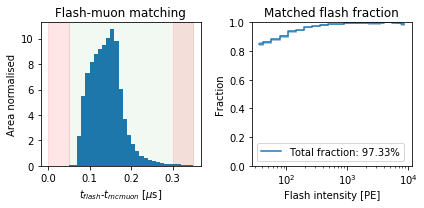

In [79]:
# make a plot of flash muon time difference and the flashmatch PE efficiency:

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
N=35
edges = np.linspace(0,0.35,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(np.array(simple_diff_times), bins=edges, density=1)
ax[0].set_xlabel(r'$t_{flash}$-$t_{mcmuon}$ [$\mu$s]')
ax[0].set_ylabel('Area normalised')
ax[0].set_title('Flash-muon matching')
ax[0].axvspan(0,0.05, alpha=0.1, color="red")
ax[0].axvspan(0.05,0.35, alpha=0.05, color="green")
ax[0].axvspan(0.3,0.35, alpha=0.1, color="red")

N=19
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
denom,_ = np.histogram(df_flash_mc.iloc[index_simple_all]['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_flash_mc.iloc[index_simple_good]['flash_totalPE'], bins=edges)
fraq = nom/denom
ratio = len(df_flash_mc.iloc[index_simple_good])/len(df_flash_mc.iloc[index_simple_all])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Total fraction: {0:.2f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')
ax[1].set_ylim(0.,1.)
ax[1].set_xlabel(r'Flash intensity [PE]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Matched flash fraction')
ax[1].set_xscale("log", nonposx='clip')
ax[1].legend()

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_primary_matching.pdf", bbox_inches="tight")

,event,run,subrun,dataset_prescale_factor,num_flashes,flash_time,flash_difftime,flash_totalPE,flash_z,flash_sz,flash_y,flash_sy,flash_width,flash_abstime,flash_num_PMT10percent,flash_difftime2
57291,4851,1,98,1.0,27,-2417.609375,-1165.21875,66,304.670349,19.824459,54.665501,0.023157,0.28125,1632.359375,2,-4629.15625
57287,4851,1,98,1.0,27,-2382.359375,-1941.37500,237,99.519424,47.054287,7.333084,42.902466,0.28125,1667.609375,6,35.25000
57288,4851,1,98,1.0,27,-2306.328125,76.03125,180,942.797302,40.909248,6.138034,44.687042,0.28125,1743.640625,7,76.03125
57279,4851,1,98,1.0,27,-2221.296875,-104.81250,573,416.334534,100.077988,-4.396087,43.942112,0.28125,1828.671875,4,85.03125
57278,4851,1,98,1.0,27,-2116.484375,-357.84375,642,295.138916,79.706566,7.953770,43.525379,0.28125,1933.484375,6,104.81250


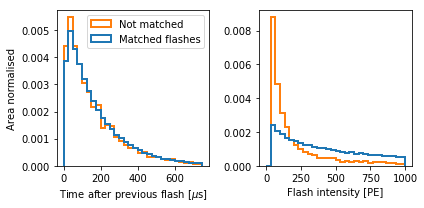

In [119]:
# The flashes arer sorted using PE, so we need to recalculate the time diff.
df_flash_mc_sorted = df_flash_mc.sort_values(by=['event','run','subrun','flash_time'])
df_flash_mc_sorted['flash_difftime2'] = df_flash_mc_sorted['flash_time']-np.roll(df_flash_mc_sorted['flash_time'],1) 

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
labs = ['Matched flashes','Not matched']

data = [df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_good)]['flash_difftime2'],
        df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_bad)]['flash_difftime2']]
ax[0].hist(data, histtype='step', density=1,bins=30,range=(0,750),lw=2, label=labs)
data = [df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_good)]['flash_totalPE'],
        df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_bad)]['flash_totalPE']]
ax[1].hist(data, histtype='step', density=1,bins=30,range=(0,1000),lw=2)
ax[0].legend()
ax[0].set_xlabel("Time after previous flash [$\mu$s]")
ax[1].set_xlabel("Flash intensity [PE]")
ax[0].set_ylabel("Area normalised")

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_latelightcheck.pdf", bbox_inches="tight")

In [87]:
df_flash_mc.columns

Index(['event', 'run', 'subrun', 'dataset_prescale_factor', 'num_flashes',
       'flash_time', 'flash_difftime', 'flash_totalPE', 'flash_z', 'flash_sz',
       'flash_y', 'flash_sy', 'flash_width', 'flash_abstime',
       'flash_num_PMT10percent'],
      dtype='object')

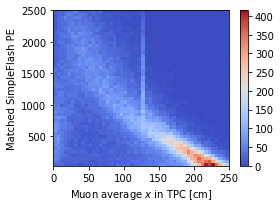

In [31]:
#print(index_simple_good)
data_fl = df_flash_mc.iloc[index_simple_good]['flash_totalPE']
data_mc_avgx = mcp_df.iloc[index_mcp_good_simple]['mc_avgx_tpc']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.hist2d(data_mc_avgx, data_fl, range=((0,250),(30,2500)), cmap='coolwarm', bins=(50,50))
plt.colorbar(c[3], ax=ax)
ax.set_xlabel('Muon average $x$ in TPC [cm]')
ax.set_ylabel('Matched SimpleFlash PE')
fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mux_flashPE.pdf", bbox_inches="tight")

In [138]:
mcp_df['mc_avgy_tpc'] = (mcp_df['mc_starty_tpc']+mcp_df['mc_endy_tpc'])/2
mcp_df['mc_avgz_tpc'] = (mcp_df['mc_startz_tpc']+mcp_df['mc_endz_tpc'])/2

mcp_df['mc_mom_x_yz'] = mcp_df['mc_startmomentumx'] / (mcp_df['mc_startmomentumy']**2+mcp_df['mc_startmomentumz']**2)**0.5
mcp_df['mc_mom_z_xy'] = mcp_df['mc_startmomentumz'] / (mcp_df['mc_startmomentumx']**2+mcp_df['mc_startmomentumy']**2)**0.5
mcp_df['mc_mom_y_zx'] = mcp_df['mc_startmomentumy'] / (mcp_df['mc_startmomentumz']**2+mcp_df['mc_startmomentumx']**2)**0.5

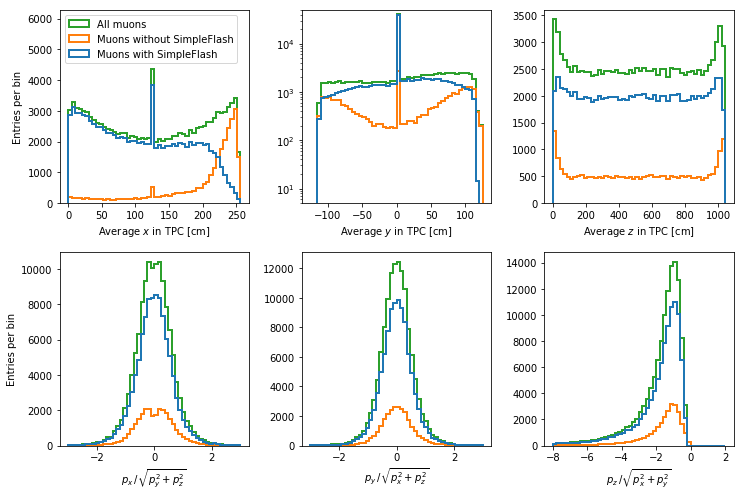

In [46]:
fig, ax = plt.subplots(2, 3, figsize=(10.5, 7))

field = 'mc_avgx_tpc'
data1 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field], mcp_df.iloc[index_mcp_all][field]]

field = 'mc_avgy_tpc'
data2 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field], mcp_df.iloc[index_mcp_all][field]]
field = 'mc_avgz_tpc'
data3 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field], mcp_df.iloc[index_mcp_all][field]]

field = 'mc_mom_x_yz'
data4 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field], mcp_df.iloc[index_mcp_all][field]]
field = 'mc_mom_z_xy'
data5 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field], mcp_df.iloc[index_mcp_all][field]]
field = 'mc_mom_y_zx'
data6 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field], mcp_df.iloc[index_mcp_all][field]]

labs = ['Muons with SimpleFlash', 'Muons without SimpleFlash', 'All muons']

ax[0][0].hist(data1,label=labs,histtype='step',lw=2,bins=50,range=(0,256))
ax[0][0].set_ylim(0,6280)
ax[0][1].hist(data2,label=labs,histtype='step',lw=2,bins=50,range=(-125,125))
ax[0][1].set_ylim(5,50000)
ax[0][2].hist(data3,label=labs,histtype='step',lw=2,bins=50,range=(0,1040))

ax[1][0].hist(data4,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][1].hist(data5,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][2].hist(data6,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-8,2))

ax[0][0].set_xlabel(r'Average $x$ in TPC [cm]')
ax[0][1].set_xlabel(r'Average $y$ in TPC [cm]')
ax[0][2].set_xlabel(r'Average $z$ in TPC [cm]')
ax[0][1].set_yscale('log')

ax[1][0].set_xlabel(r'$p_x \:/ \sqrt{p_y^2+p_z^2}$')
ax[1][1].set_xlabel(r'$p_y \:/ \sqrt{p_x^2+p_z^2}$')
ax[1][2].set_xlabel(r'$p_z \:/ \sqrt{p_x^2+p_y^2}$')

ax[0][0].set_ylabel('Entries per bin')
ax[1][0].set_ylabel('Entries per bin')
ax[0][0].legend(loc='upper left')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muons2.pdf", bbox_inches="tight")

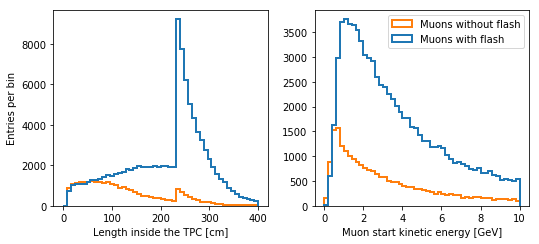

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(7.6, 3.5))

field = 'mc_length_tpc'
data1 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field]]
field = 'Kinetic Energy'
data2 = [mcp_df.iloc[index_mcp_good_simple][field], mcp_df.iloc[index_mcp_bad][field]]


labs = ['Muons with flash', 'Muons without flash']
ax[0].hist(data1,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,400))
ax[1].hist(data2,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,10))

ax[0].set_xlabel('Length inside the TPC [cm]')
ax[1].set_xlabel('Muon start kinetic energy [GeV]')

ax[0].set_ylabel('Entries per bin')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muons1.pdf", bbox_inches="tight")

In [139]:
# We match 94% of all muons if they are x<200 and z inside [50,990] and energy of 1GeV. Good!
query_easy_muons = '(mc_avgx_tpc < 200) & (mc_avgz_tpc > 50) & (mc_avgz_tpc < 990)  \
                  & (mc_energy>1)' 
len(mcp_df.iloc[index_mcp_good_simple].query(query_easy_muons))/len(mcp_df.iloc[index_mcp_all].query(query_easy_muons))

0.9429218101642884

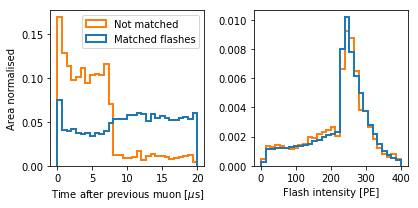

In [140]:
df_easy_muons = mcp_df.query(query_easy_muons)

# The flashes arer sorted using PE, so we need to recalculate the time diff.
df_muons_sorted = mcp_df.sort_values(by=['event','run','subrun','mc_time'])
df_muons_sorted['mc_difftime'] = df_muons_sorted['mc_time']-np.roll(df_muons_sorted['mc_time'],1) 
df_easy_muons_sorted = df_muons_sorted.query(query_easy_muons)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
labs = ['Matched flashes','Not matched']

data = [df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_good_simple)]['mc_difftime']/1000,
        df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_bad)]['mc_difftime']/1000]
ax[0].hist(data, histtype='step', density=1,bins=30,range=(0,20),lw=2, label=labs)
data = [df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_good_simple)]['mc_length_tpc'],
        df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_bad)]['mc_length_tpc']]
ax[1].hist(data, histtype='step', density=1,bins=30,range=(0,400),lw=2)
ax[0].legend()
ax[0].set_xlabel("Time after previous muon [$\mu$s]")
ax[1].set_xlabel("Flash intensity [PE]")
ax[0].set_ylabel("Area normalised")

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/sequentialmuoncheck.pdf", bbox_inches="tight")


In [150]:
# Find the easy muons that did not trigger a flash because of another flash:
diff_time = []

muon_df = mcp_df.iloc[index_mcp_bad].query(query_easy_muons)
print(len(muon_df))
for index, row in muon_df.iterrows():
    event,run,subrun = row[['event','run','subrun']]
    selection_string = 'event==@event & run==@run & subrun==@subrun'
    flash_times = df_flash_mc.query(selection_string)['flash_time'].values
    mc_time = row['mc_time']/1000
    temp = flash_times-mc_time
    if(len(temp[temp<0.05])>0):
        temp_diff = max(temp[temp<0.05])
        diff_time.append(temp_diff)
        
print(sum(np.array(diff_time)>-8))

4388
1371


(array([1371.,  124.,  121.,  111.,  110.,  114.,  120.,   97.,   85.,
          88.,   98.,   76.,   87.,   85.,   77.,   69.,   70.,   70.,
          49.,   47.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160.],
       dtype=float32),
 <a list of 20 Patch objects>)

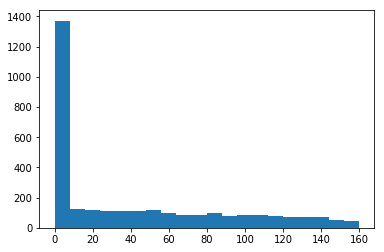

In [155]:
plt.hist(abs(np.array(diff_time)), bins=20, range=(0,160))